# Authorship of the Federalist Papers

The _Federalist Papers_ were a set of 85 essays published between 1787 and 1788 to promote the ratification of the United States Constitution. They were originally published under the pseudonym "Publius". Although the identity of the authors was a closely guarded secret at the time, most of the papers have since been conclusively attributed to one of Hamilton, Jay, or Madison. The known authorships can be found in `/data301/data/federalist/authorship.csv`.

For 15 of the papers, however, the authorships remain disputed. (These papers can be identified from the `authorship.csv` file because the "Author" field is blank.) In this analysis, you will train a classifier on the papers with known authorships and use your classifier to predict the authorships of the disputed papers. The text of each paper can be found in the `/data301/data/federalist/` directory. The name of the file indicates the number of the paper.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

## Question 1

When analyzing an author's style, common words like "the" and "on" are actually more useful than rare words like "hostilities". That is because rare words typically signify context. Context is useful if you are trying to find documents about similar topics, but not so useful if you are trying to identify an author's style because different authors can write about the same topic. For example, both Dr. Seuss and Charles Dickens used rare words like "chimney" and "stockings" in _How the Grinch Stole Christmas_ and _A Christmas Carol_, respectively. But they used common words very differently: Dickens used the word "upon" over 100 times, while Dr. Seuss did not use "upon" at all.

Read in the Federalist Papers. Convert each one into a vector of term frequencies. In order to restrict to common words, include only the top 50 words. Then, train a $k$-nearest neighbors model on the documents with known authorship. Determine an optimal value of $k$ (it's up to you to decide what's "optimal"). 

Report an estimate of the test accuracy, precision, and recall of your model.

In [2]:
from glob import glob

filenames = sorted(glob("/data301/data/federalist/*.txt"), 
                   key=lambda f: int(''.join(filter(str.isdigit, f))))
essay_df = pd.DataFrame()
for file in filenames:
    text = open(file).read().replace("\n", " ")
    essay_df = essay_df.append({"Corpus": text}, ignore_index=True)
authors_df = pd.read_csv("/data301/data/federalist/authorship.csv")
essay_df["Author"] = authors_df.Author
essay_df.head()

,Corpus,Author
0,To the People of the State of New York: AFTER...,Hamilton
1,To the People of the State of New York: WHEN ...,Jay
2,To the People of the State of New York: IT IS...,Jay
3,To the People of the State of New York: MY LA...,Jay
4,To the People of the State of New York: QUEEN...,Jay


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
vec = CountVectorizer(max_features=50)
model = KNeighborsClassifier()

pipeline = Pipeline([
    ("vec", vec),
    ("model", model)
])

X, y = essay_df.dropna().Corpus, essay_df.dropna().Author
X_test = essay_df[essay_df.Author.isnull()].Corpus

In [4]:
from sklearn.model_selection import GridSearchCV

k = range(1, 10, 1)
pg = {
    "model__n_neighbors": k
}

classifier_model = GridSearchCV(
    pipeline, pg, cv=5, scoring={
    "f1": "f1_macro",
    "acc": "accuracy",
    "rec": "recall_macro",
    "prec": "precision_macro"},
    refit="f1")

classifier_model.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_ac...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'model__n_neighbors': range(1, 10)},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score='warn',
       scoring={'f1': 'f1_macro', 'acc': 'accuracy', 'rec': 'recall_macro', 'prec': 'precision_macro'},
       verbose=0)

{'model__n_neighbors': 5} 0.721781972341


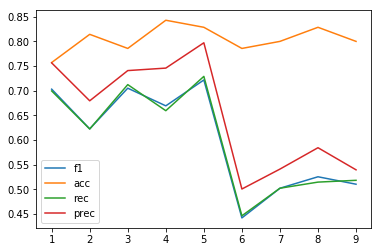

In [5]:
pd.DataFrame({"f1": classifier_model.cv_results_["mean_test_f1"],
              "acc": classifier_model.cv_results_["mean_test_acc"],
              "rec": classifier_model.cv_results_["mean_test_rec"],
              "prec": classifier_model.cv_results_["mean_test_prec"]
             }, 
             index=k).plot()
print(classifier_model.best_params_,
      classifier_model.best_score_)

We can see from our plot and gridsearch that KNN is best with 5 neighbors with our data. This makes sense as our dataset is small, and we are only using 50 features as well.

## Question 2

What if we used TF-IDF on the top 50 words instead of the term frequencies? Repeat Question 1, using TF-IDF instead of TF. Which approach is better: TF-IDF or TF?

In [6]:
vec = TfidfVectorizer(max_features=50)
model = KNeighborsClassifier()

pipeline = Pipeline([
    ("vec", vec),
    ("model", model)
])

pg = {
    "model__n_neighbors": k
}

classifier_model = GridSearchCV(
    pipeline, pg, cv=5, scoring={
    "f1": "f1_macro",
    "acc": "accuracy",
    "rec": "recall_macro",
    "prec": "precision_macro"},
    refit="f1")

classifier_model.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'model__n_neighbors': range(1, 10)},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score='warn',
       scoring={'f1': 'f1_macro', 'acc': 'accuracy', 'rec': 'recall_macro', 'prec': 'precision_macro'},
       verbose=0)

{'model__n_neighbors': 5} 0.909206349206


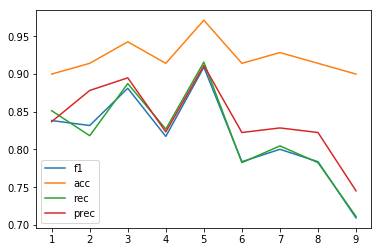

In [7]:
pd.DataFrame({"f1": classifier_model.cv_results_["mean_test_f1"],
              "acc": classifier_model.cv_results_["mean_test_acc"],
              "rec": classifier_model.cv_results_["mean_test_rec"],
              "prec": classifier_model.cv_results_["mean_test_prec"]
             }, 
             index=k).plot()
print(classifier_model.best_params_,
      classifier_model.best_score_)

The TFIDF approach is better here, since an author will most likely have similar term frequencies in other documents that they write.

## Question 3

Using the model that you determined to be best in Questions 1 and 2, fit a $k$-nearest neighbors model to all 70 documents with known authorship. Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for your model that shows how often you predicted Hamilton, Jay, or Madison, and how often it actually was Hamilton, Jay, or Madison (on the training data, of course). 

From your confusion matrix, you should be able to calculate the (training) precision and recall of your model for predicting Hamilton. What is it?

In [8]:
from sklearn.metrics import confusion_matrix

y_pred = classifier_model.predict(X)
conf_df = pd.DataFrame(confusion_matrix(
    y, y_pred, labels=["Hamilton", "Madison", "Jay"]))
conf_df.columns = ["Hamilton (True)", 
                   "Madison (True)", 
                   "Jay (True)"]
conf_df.index = ["Hamilton (Pred)", 
                 "Madison (Pred)", 
                 "Jay (Pred)"]
conf_df

,Hamilton (True),Madison (True),Jay (True)
Hamilton (Pred),51,0,0
Madison (Pred),1,13,0
Jay (Pred),0,1,4


We see that we were able to predict the correct authors a majority of the time. We only mispredicted a few times: once where we predicted Madison instead of Hamilton, and Hamilton instead of Madison. This is probably because their writings appears to be very similar in prose.

## Question 4

Finally, use the model you trained in Question 3 to predict the authorships of the 15 documents with unknown authors. Summarize what you find.

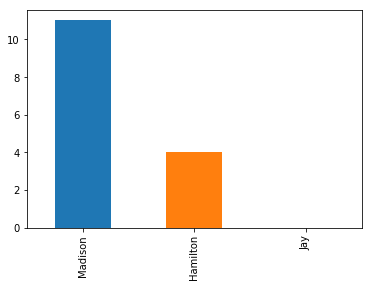

In [10]:
(pd.Series(classifier_model.predict(X_test))
 .value_counts().append(pd.Series({"Jay": 0}))
 .plot.bar())

We see that our predictions include a majority of Madison, some Hamilton, and zero Jay.

# Submission Instructions

Once you are finished, follow these steps:

1. Restart the kernel and re-run this notebook from beginning to end by going to `Kernel > Restart Kernel and Run All Cells`.
2. If this process stops halfway through, that means there was an error. Correct the error and repeat Step 1 until the notebook runs from beginning to end.
3. Double check that there is a number next to each code cell and that these numbers are in order.

Then, submit your lab as follows:

1. Go to `File > Export Notebook As > PDF`.
2. Double check that the entire notebook, from beginning to end, is in this PDF file. (If the notebook is cut off, try first exporting the notebook to HTML and printing to PDF.)
3. Upload the PDF [to PolyLearn](https://polylearn.calpoly.edu/AY_2018-2019/mod/assign/view.php?id=336786).